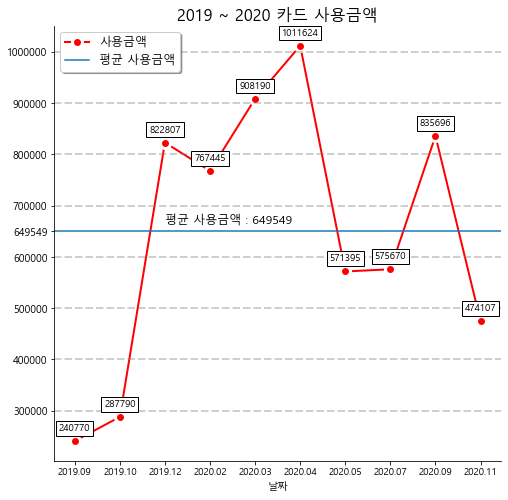

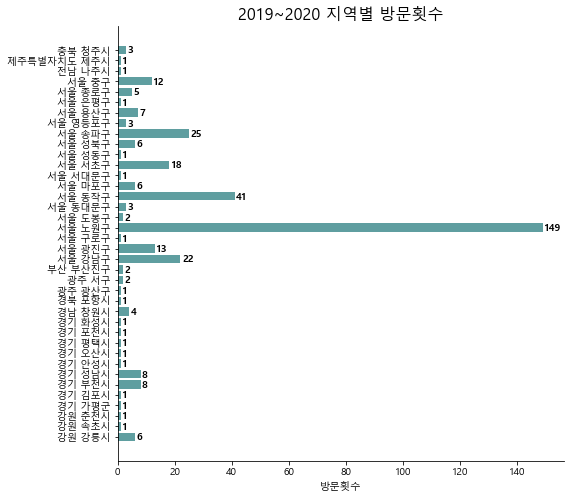

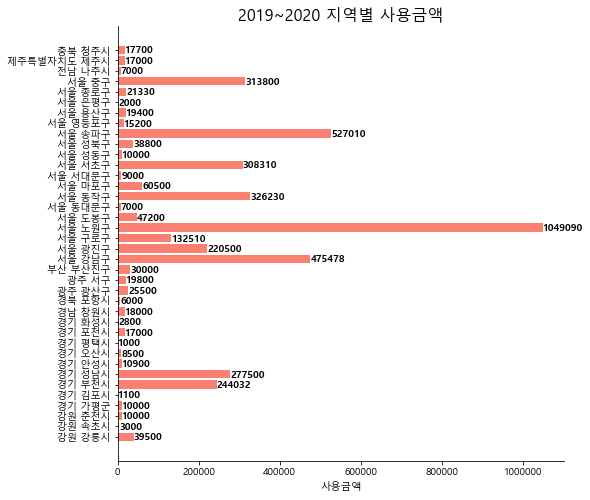

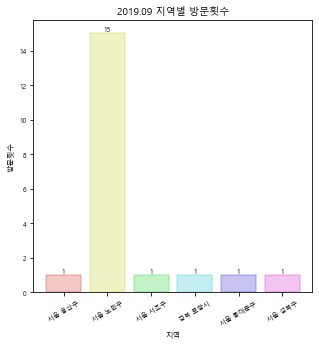

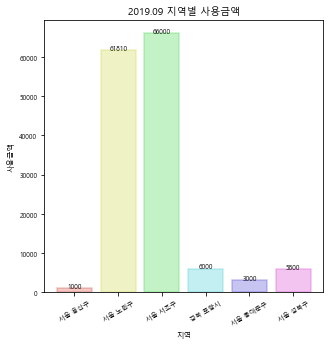

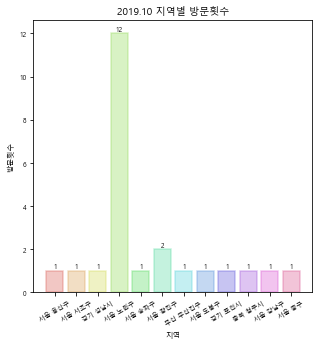

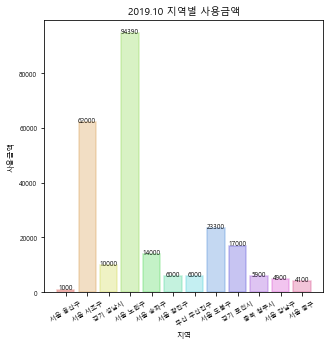

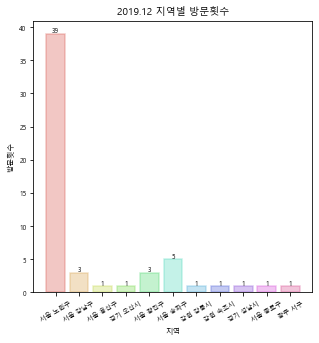

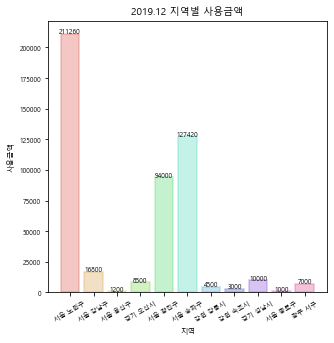

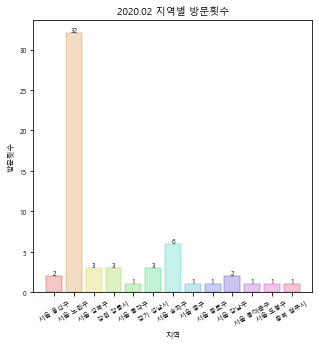

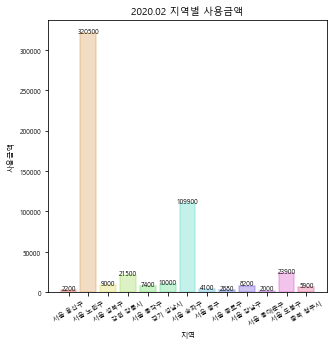

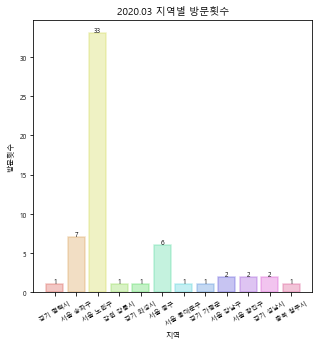

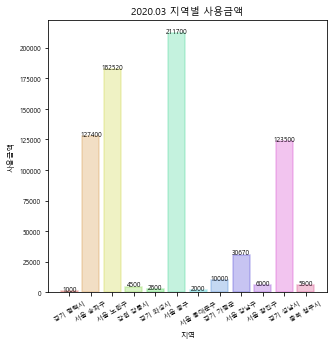

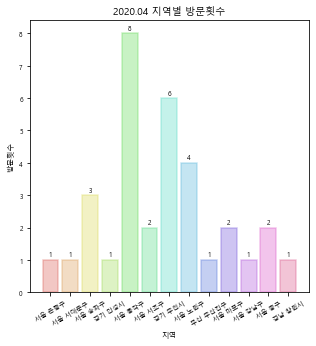

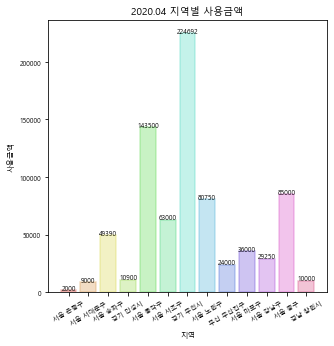

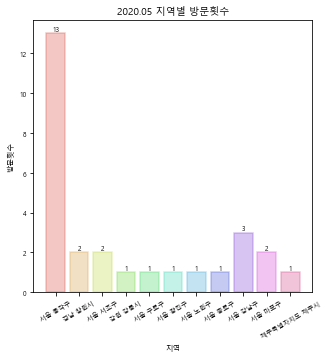

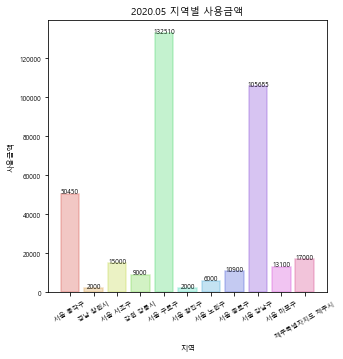

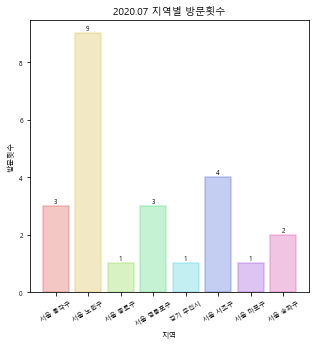

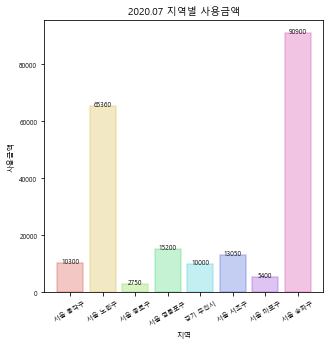

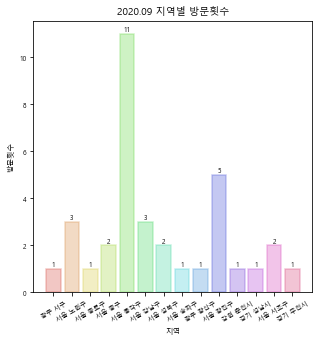

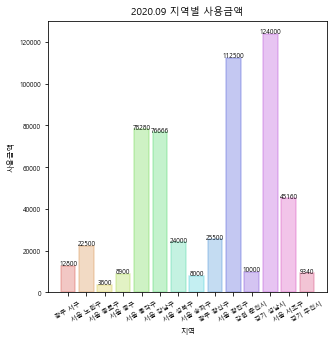

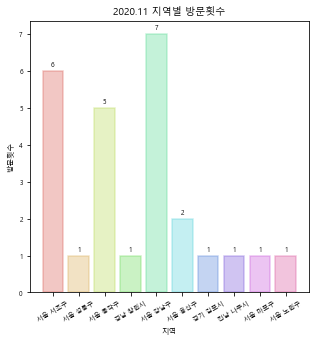

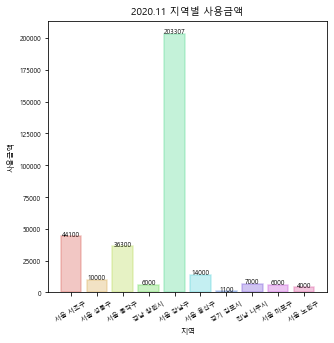

In [202]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
from selenium import webdriver
import requests 
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False 

# 체크카드 명세서 자동 불러오기
receipt_data_file = glob.glob('C:/Users/Playdata/Desktop/shinhancard/shinhancard_*.html') # 지정 폴더안에 있는 모든 파일을 불러내기 위함

# excel_writer로 보낼 data 모음
total_df = []             # 일별 DataFrame 모음
total_df_region = []      # 지역별 DataFrame 모음
List_Sum_Month_tdf = []   # 월별 합계 DataFrame 모음
sheet_nm = []             # Excel Sheet Name 모음
visit_graph = []          # 월기준 지역별 방문횟수 그래프 모음
price_graph = []         # 월기준 지역별 사용금액 그래프 모음


# 위의 'total_df'와 'sheet_nm'에 데이터를 삽입하기 위한 for 구문
for url in receipt_data_file :
    driver = webdriver.Chrome('c:/chromedriver.exe')
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')

    title_tag = soup.select('head > title')
    title = title_tag[0].text
    
    # 암호된 문서일 경우 if 구문으로 들어감
    if title == '' :
        pw = '950730'
        driver.find_element_by_id('password').send_keys(pw)
        driver.find_element_by_xpath('//*[@id="aform"]/span/input').click()
        time.sleep(5)
        html = driver.page_source
        soup = BeautifulSoup(html,'html.parser')
        
    # 암호된 문서가 아닐 경우 아래코드로 바로 들어감
    # 명세서 데이터에서 체크 소계 제거 코드
    tables = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr')
    tables_middleSum = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr.middleSum')
    
    for n in range(len(tables_middleSum)) :
        tables.remove(tables_middleSum[n])
    
    # tables 데이터 string으로 변환하여 분리                      
    seperate_tables = []                        # seperate_tables 초기화
    for n in range(len(tables)) :
        table = str(tables[n].text).split('\n')
        seperate_tables = seperate_tables + table
        
    # seperate_tables에서 '사용날짜' , '사용금액', '사용처' 추출   
    date_list =  [seperate_tables[n] for n in range(1,len(seperate_tables), 12)]
    price_list = [int(seperate_tables[n].replace(',','')) for n in range(4,len(seperate_tables), 12)] 
    store_list = [seperate_tables[n].replace(" ", "") for n in range(3,len(seperate_tables), 12)]

    # seperate_tables에서 추출된 '사용처' 데이터 --> 카카오 지도 API --> '사용처'에 대한 주소 추출
    location_list = []
    def create_url(search_text):
        headers = {'Authorization': 'KakaoAK 3e8ea332f0cdef6293383ac7bf81a6fc'}
        base = "https://dapi.kakao.com/v2/local/search/keyword.json"
        param_query = "?query=" +search_text
        respond = requests.get(base + param_query,headers=headers)
        return respond.json()

    for n in range(len(store_list)) :
        store_name = store_list[n]
        result = create_url(store_name)
        tmp1 = result['documents']
        try :
            tmp2 = tmp1[0]['address_name']
            location_list.append(tmp2)
        except :
            tmp2 = np.nan
            location_list.append(tmp2)
            
    # 추출한 데이터로 DataFrame 변환
    table_data = {'사용날짜':date_list, '사용처':store_list, '사용처주소':location_list,  '사용금액':price_list }
    
    df = pd.DataFrame(table_data, index = range(1,len(date_list)+1,1), columns=['사용날짜', '사용처', '사용처주소', '사용금액'])
    df_sum = pd.DataFrame(df.sum(), columns=['합계'])
    df_total = df.append(df_sum.T)
    df_total.loc['합계', '사용날짜'] = '전체'
    df_total.loc['합계', '사용처'] = '전체'
    df_total.loc['합계', '사용처주소'] = '전체'
    total_df.append(df_total)
    List_Sum_Month_tdf.append(df_sum.T['사용금액'])    # 선그래프를 그리기 위한 합계를 List_Sum_Month_tdf=[]로 보낸다.
        
   # 월별기준 지역별 사용데이터 추출  
    df_dis_nan = df.dropna()

    df_address_list = list(df_dis_nan['사용처주소'])
    df_region_list = [ ' '.join(address.split()[:2]) for address in df_address_list]

    df_price_list = list(df_dis_nan['사용금액'])

    table_data_1 = {'사용지역':df_region_list, '사용금액':df_price_list}
    col_list = ['사용지역', '사용금액']
    df_Dup = pd.DataFrame(table_data_1 , columns = col_list ) # 중복값이 있는 df
    df_NoDup = df_Dup.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df

    index_name_1 = df_Dup['사용지역']  # 중복값이 있는 사용지역 series
    df_Dup_name = df_Dup.rename(index_name_1)
    df_Dup_name = df_Dup_name.drop(['사용지역'], axis = 1)  # 중복값이 있고 사용지역이 index인 df

    index_name_2 = df_NoDup['사용지역']  # 중복값이 없는 사용지역 series
    df_NoDup_name = df_NoDup.rename(index_name_2)
    df_NoDup_name = df_NoDup_name.drop(['사용지역'], axis = 1)  # 중복값이 없고 사용지역이 index인 df

    for nm in list(index_name_2) :
        price_data = df_Dup_name.loc[nm]['사용금액']
        price_sum = price_data.sum()
        df_NoDup_name.loc[nm]['사용금액'] = price_sum

    name_region = df_Dup['사용지역']
    visit_counter = dict(name_region.value_counts())
    counter_list = []
    for k in index_name_2 :
        counter_list.append(visit_counter[k])
    
    df_NoDup_name.insert(0, '방문횟수', counter_list)
    total_df_region.append(df_NoDup_name)
    
    # 엑셀 시트네임 데이터 추출
    tables_date = soup.select('body > div.wrap.check > div.content > div.receiveDate > span.date')
    nm = str(tables_date[0].text)
    sheet_nm.append(nm)
    
    # 팝업창 닫기
    driver.close()

# 엑셀 및 이미지 저장 폴더 만들기
folder = 'C:/Users/Playdata/Desktop/체크카드 명세서'
folder_1 = 'C:/Users/Playdata/Desktop/체크카드 명세서/image'

if not os.path.exists(folder) :
    os.makedirs(folder)

if not os.path.exists(folder_1) :
    os.makedirs(folder_1)
    
# 월별 사용금액 데이터 시각화(엑셀 첫번째 시트에 들어감)
     
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=2, # 선 두께 
    marker='o', # 마커 모양
    markersize=10, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=3, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(2,mean_sales+15000,f'평균 사용금액 : {mean_sales}',fontsize=12) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=9.6, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=12, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=10.4) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=9.6) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('',rotation=90, fontsize=16, color='black') ## y축 라벨
plt.xlabel('날짜',fontsize=10.4, color='black') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=16, color='black') ## 타이틀 설정

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

########## 시각화를 위한 dataframe #############################

df_region_Dup = pd.DataFrame()        # 중복값이 있는 df_region

for n in range(len(total_df_region)) :
        df_region_Dup = df_region_Dup.append(total_df_region[n])

sorted_df_region_Dup = df_region_Dup.sort_index(ascending=True)  # 오름차순이 적용된 중복값이 있는 df_region

index_region = sorted_df_region_Dup.reset_index().rename(columns={'index': '사용지역'}) # index를 columns로 전환

df_region_NoDup = index_region.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df_region

index_name_3 = df_region_NoDup['사용지역']  
df_region_NoDup_name = df_region_NoDup.rename(index_name_3)
df_region_NoDup_name = df_region_NoDup_name.drop(['사용지역'], axis = 1) # 중복값이 없고 사용지역이 index인 df_region

for nm_1 in list(index_name_3) :
    price_region_data = sorted_df_region_Dup.loc[nm_1]['사용금액']
    price_region_sum = price_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['사용금액'] = price_region_sum        # 지역별 총 사용금액 데이터 삽입
    
    visit_region_data = sorted_df_region_Dup.loc[nm_1]['방문횟수']
    visit_region_sum = visit_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['방문횟수'] = visit_region_sum        # 지역별 총 방문횟수 데이터 삽입

################ 1년간 지역별 총 방문횟수 시각화 ################
## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']
total_price_category = df_region_NoDup_name['사용금액']

## 시각화
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position, total_region_category) ## y축 눈금 라벨 출력

plt.barh(ytick_label_position, total_visit_category, color = 'cadetblue') ## 바차트 출력

for i, v in enumerate(total_visit_category):
    plt.text(v + .5, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 방문횟수',fontsize=16) ## 타이틀 출력
plt.xlabel('방문횟수',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_1 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)
plt.show()

##### 2019~2020 지역별 총 사용금액 ####
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position_1 = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position_1, total_region_category) ## y축 눈금 라벨 출력
plt.gca().get_xaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기

plt.barh(ytick_label_position_1, total_price_category, color = 'salmon') ## 바차트 출력

for i, v in enumerate(total_price_category):
    plt.text(v + 1, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 사용금액',fontsize=16) ## 타이틀 출력
plt.xlabel('사용금액',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_2 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_price.png"
plt.savefig(graph_file_2, dpi = 200)

plt.show()
###################################################

# 월기준 지역 방문횟수 및 사용금액 데이터 시각화(해당 월별 시트에 각각 들어감)

for n in range(len(total_df_region)) :
    c_name = ['방문횟수', '사용금액']
    ta = total_df_region[n]
    sn = sheet_nm[n]
    for k in range(len(c_name)) :
            region_category = ta.index
            visit_category = ta[c_name[k]]
            
            tick_size_1 = 6.5 ## 눈금 폰트 사이즈
            axis_label_size_1 = 7.5 ## x축, y축 폰트 사이즈

            fig_1 = plt.figure(figsize=(5,5)) ## Figure 생성 사이즈는 10 by 10
            ax_1 = fig_1.add_subplot() ## Axes 추가
            colors_1 = sns.color_palette('hls',len(region_category)) ## 색상 지정

            xtick_label_position = list(range(len(region_category))) ## x축 눈금 라벨이 표시될 x좌표

            plt.yticks(fontsize=tick_size_1)
            plt.xticks(xtick_label_position, region_category, rotation = 30, fontsize=tick_size_1) ## x축 눈금 라벨 출력

            bars = plt.bar(xtick_label_position, visit_category, color=colors_1, \
                           edgecolor=colors_1, alpha=0.35, linewidth=1.5) ## 바차트 출력

            for i, b in enumerate(bars):
                ax_1.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                        visit_category[i],ha='center',fontsize=6.5)

            plt.title(f'{sn} 지역별 {c_name[k]}',fontsize=10) ## 타이틀 출력
            plt.xlabel('지역',fontsize=axis_label_size_1) ## x축 라벨 출력
            plt.ylabel(c_name[k],fontsize=axis_label_size_1) ## y축 라벨 출력
            visit_file = f"C:/Users/Playdata/Desktop/체크카드 명세서/image/{sn}_{c_name[k]}.png"
            plt.savefig(visit_file, dpi = 200)
            
            if c_name[k] == '방문횟수' : 
                visit_graph.append(visit_file)
                
            else :
                price_graph.append(visit_file)
            
# total_df, total_df_region, sheet_nm 데이터를 활용하여 Excel로 저장
    
excel_writer = pd.ExcelWriter('C:/Users/Playdata/Desktop/체크카드 명세서/CardUseList.xlsx', engine='xlsxwriter')

df_empty = pd.DataFrame()
df_empty.to_excel(excel_writer, index = True, sheet_name = 'Sheet1')
worksheet = excel_writer.sheets['Sheet1']
worksheet.insert_image('A1', graph_file) 
worksheet.insert_image('N1', graph_file_1)
worksheet.insert_image('AA1', graph_file_2)


ToExcel_data =[]

for n in range(len(total_df)) :
    ToAppend_total_df = total_df[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터')
    ToExcel_data.append(ToAppend_total_df)
    
    ToAppend_total_region_df = total_df_region[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터', startcol=6)
    worksheet_1 = excel_writer.sheets[sheet_nm[n]+' 데이터']
    send_worksheet_1 = worksheet_1.insert_image('K1', visit_graph[n])
    send_worksheet_2 = worksheet_1.insert_image('S1', price_graph[n])
    ToExcel_data.append(ToAppend_total_region_df)
    ToExcel_data.append(send_worksheet_1)

excel_writer.save()

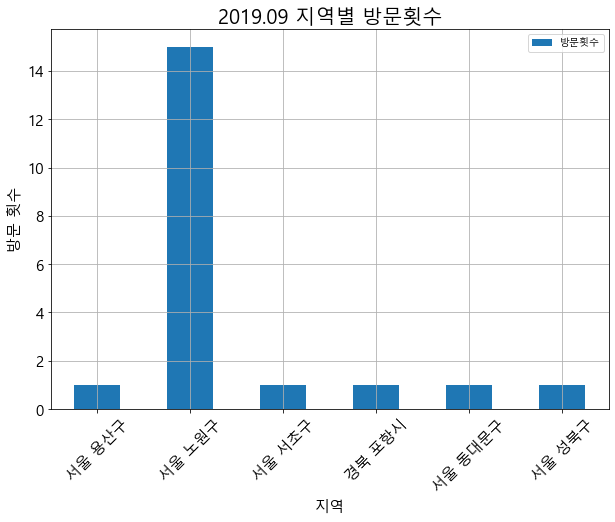

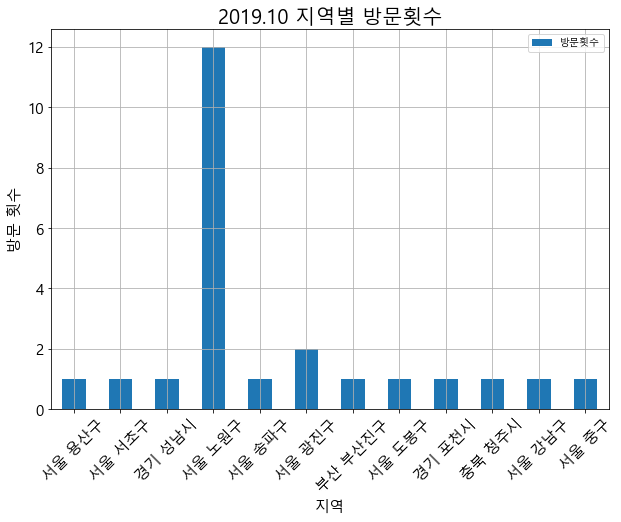

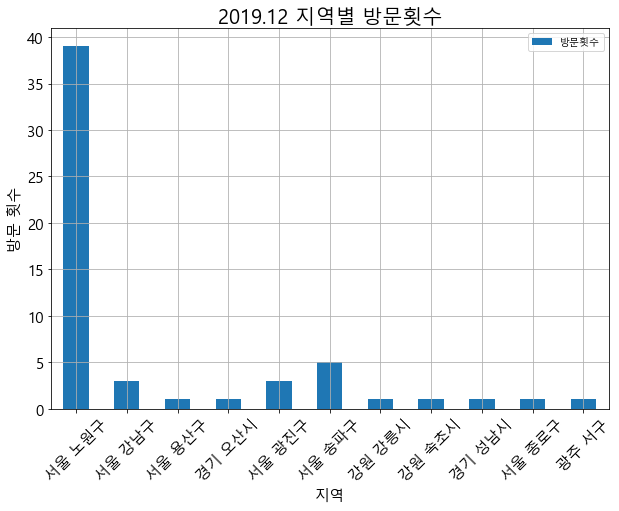

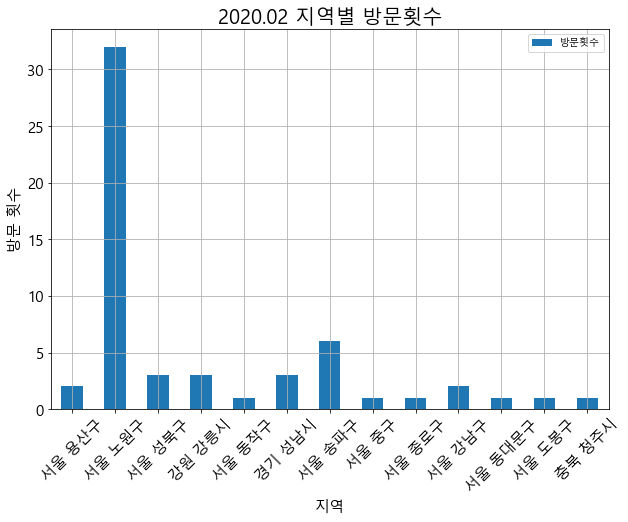

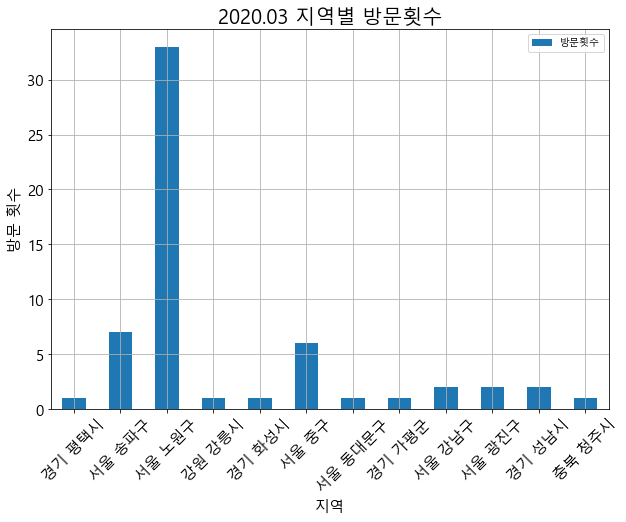

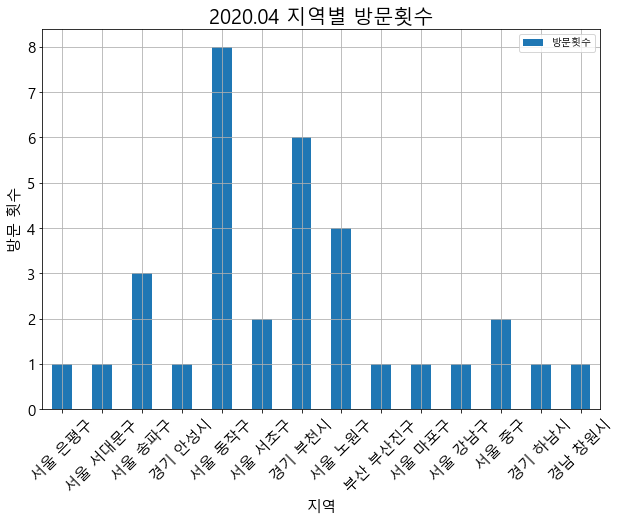

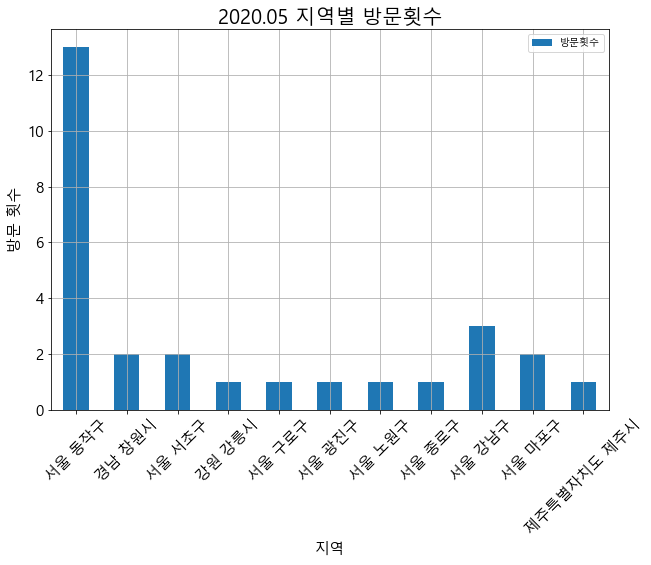

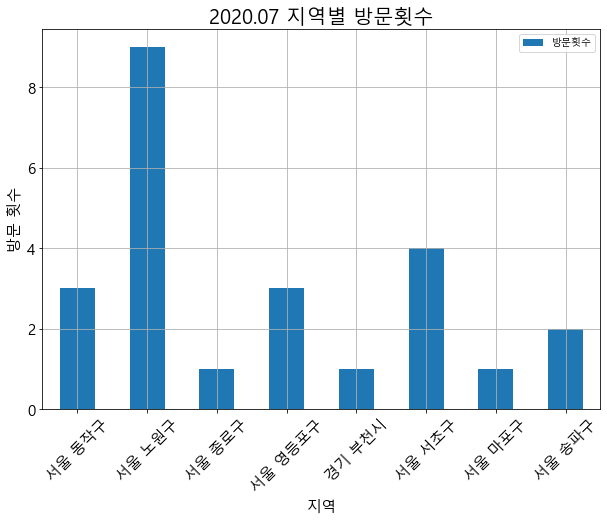

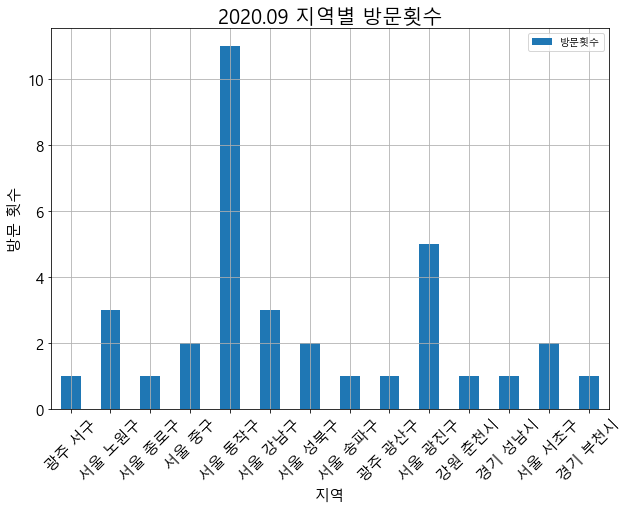

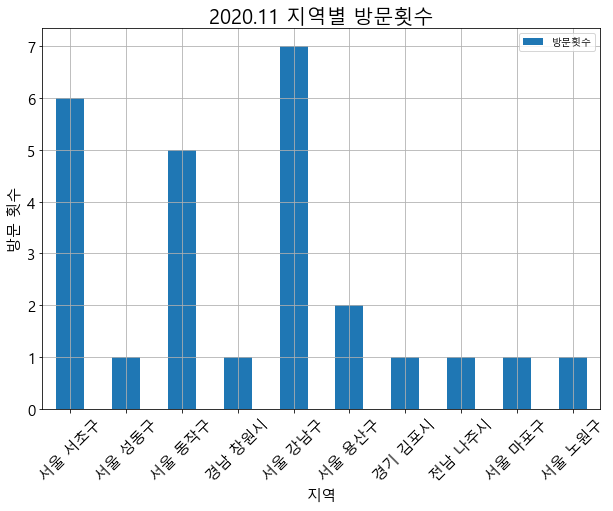

In [79]:
visit_graph=[]

for n in range(len(total_df_region)) :
    a0 = total_df_region[n][["방문횟수"]].plot.bar(grid = True, rot=45, figsize=[10,7], fontsize = 15)
    a0.set_xlabel("지역",fontsize = 15)
    a0.set_ylabel("방문 횟수",fontsize = 15)
    a0.set_title(f"{sheet_nm[n]} 지역별 방문횟수", fontsize = 20)
    plt.xticks(rotation=45)
    visit_file = f"C:/Users/again/Desktop/체크카드 명세서/{sheet_nm[n]} 지역별 사용 금액.png" 
    plt.savefig(visit_file,dpi = 200)
    visit_graph.append(visit_file)

In [ ]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False      
    
plt.subplots(1,1, figsize=[10,7])
plt.plot(sheet_nm, List_Sum_Month_tdf, 'o-r')

plt.xticks(rotation=360)

plt.tick_params(axis='x', labelsize=12, color='r')
plt.tick_params(axis='y', labelsize=12, color='r')

plt.xlabel('날짜', fontsize = 15)
plt.ylabel('사용 금액', fontsize = 15)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)  # 지수 표현 방지
plt.title('월별 카드 사용 금액', fontsize = 15)

plt.grid(True)

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

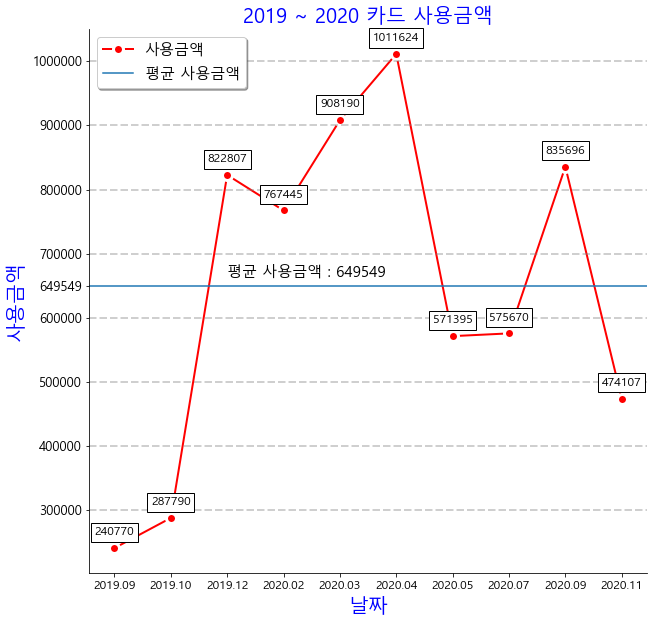

In [47]:
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=2, # 선 두께 
    marker='o', # 마커 모양
    markersize=10, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=3, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(2,mean_sales+15000,f'평균 사용금액 : {mean_sales}',fontsize=15) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=12, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=15, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=13) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=12) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('사용금액',rotation=90, fontsize=20, color='blue') ## y축 라벨
plt.xlabel('날짜',fontsize=20, color='blue') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=20, color='blue') ## 타이틀 설정

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

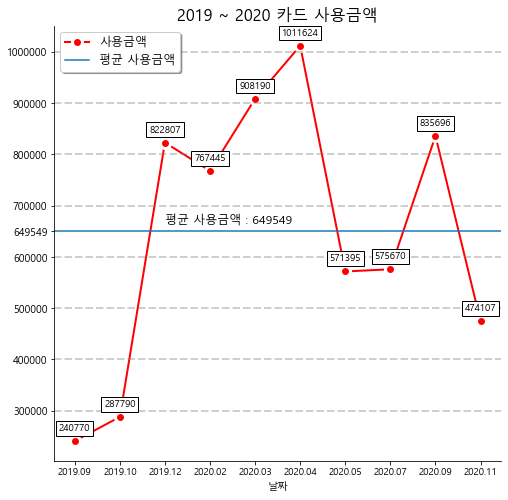

In [165]:
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=2, # 선 두께 
    marker='o', # 마커 모양
    markersize=10, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=3, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(2,mean_sales+15000,f'평균 사용금액 : {mean_sales}',fontsize=12) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=9.6, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=12, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=10.4) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=9.6) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('',rotation=90, fontsize=16, color='black') ## y축 라벨
plt.xlabel('날짜',fontsize=10.4, color='black') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=16, color='black') ## 타이틀 설정

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

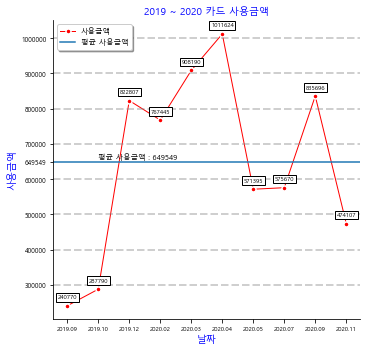

In [160]:
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(5.5,5.5)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=1, # 선 두께 
    marker='o', # 마커 모양
    markersize=5, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=1.5, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(1,mean_sales+(15000/2),f'평균 사용금액 : {mean_sales}',fontsize=7.5) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=6, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=7.5, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=6.5) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=6) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('사용금액',rotation=90, fontsize=10, color='blue') ## y축 라벨
plt.xlabel('날짜',fontsize=10, color='blue') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=10, color='blue') ## 타이틀 설정

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

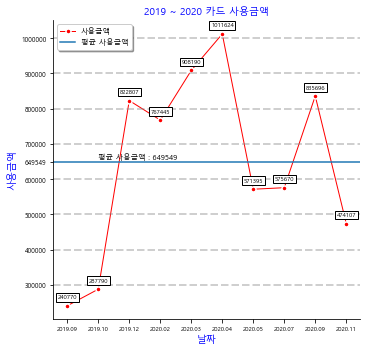

In [8]:
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(5.5,5.5)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=1, # 선 두께 
    marker='o', # 마커 모양
    markersize=5, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=1.5, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(1,mean_sales+(15000/2),f'평균 사용금액 : {mean_sales}',fontsize=7.5) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=6, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=7.5, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=6.5) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=6) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('사용금액',rotation=90, fontsize=10, color='blue') ## y축 라벨
plt.xlabel('날짜',fontsize=10, color='blue') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=10, color='blue') ## 타이틀 설정

graph_file = "C:/Users/Playdata/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

In [76]:
df_region_Dup = pd.DataFrame()        # 중복값이 있는 df_region

for n in range(len(total_df_region)) :
        df_region_Dup = df_region_Dup.append(total_df_region[n])

sorted_df_region_Dup = df_region_Dup.sort_index(ascending=True)  # 오름차순이 적용된 중복값이 있는 df_region

index_region = sorted_df_region_Dup.reset_index().rename(columns={'index': '사용지역'}) # index를 columns로 전환

df_region_NoDup = index_region.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df_region

index_name_3 = df_region_NoDup['사용지역']  
df_region_NoDup_name = df_region_NoDup.rename(index_name_3)
df_region_NoDup_name = df_region_NoDup_name.drop(['사용지역'], axis = 1) # 중복값이 없고 사용지역이 index인 df_region

for nm_1 in list(index_name_3) :
    price_region_data = sorted_df_region_Dup.loc[nm_1]['사용금액']
    price_region_sum = price_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['사용금액'] = price_region_sum        # 지역별 총 사용금액 데이터 삽입
    
    visit_region_data = sorted_df_region_Dup.loc[nm_1]['방문횟수']
    visit_region_sum = visit_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['방문횟수'] = visit_region_sum        # 지역별 총 방문횟수 데이터 삽입

In [77]:
df_region_NoDup_name

,방문횟수,사용금액
강원 강릉시,6,39500
강원 속초시,1,3000
강원 춘천시,1,10000
경기 가평군,1,10000
경기 김포시,1,1100
경기 부천시,8,244032
경기 성남시,8,277500
경기 안성시,1,10900
경기 오산시,1,8500
경기 평택시,1,1000


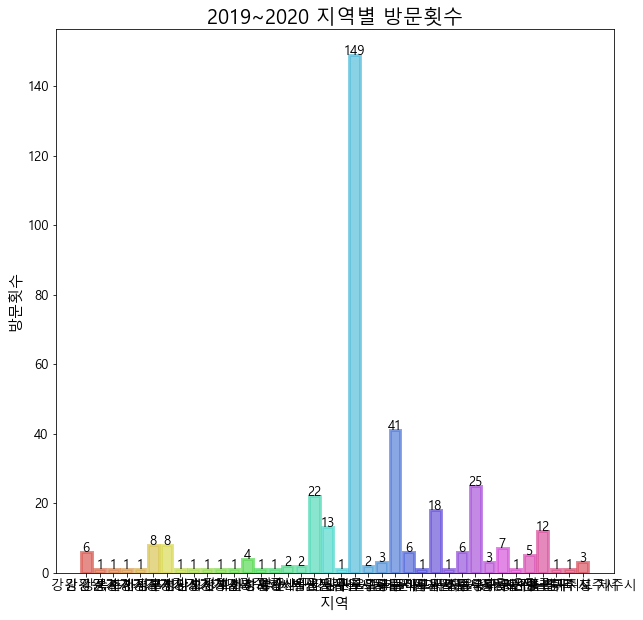

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
 
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']

## 시각화
tick_size_1 = 13 ## 눈금 폰트 사이즈
axis_label_size_1 = 15 ## x축, y축 폰트 사이즈

fig_1 = plt.figure(figsize=(10,10)) ## Figure 생성 사이즈는 10 by 10
ax_1 = fig_1.add_subplot() ## Axes 추가
colors_1 = sns.color_palette('hls',len(total_region_category)) ## 색상 지정

xtick_label_position = list(range(len(total_region_category))) ## x축 눈금 라벨이 표시될 x좌표

plt.yticks(fontsize=tick_size_1)
plt.xticks(xtick_label_position, total_region_category, fontsize=tick_size_1) ## x축 눈금 라벨 출력

bars = plt.bar(xtick_label_position, total_visit_category, color=colors_1, \
               edgecolor=colors_1, alpha=0.7, linewidth=3) ## 바차트 출력

for i, b in enumerate(bars):
    ax_1.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            total_visit_category[i],ha='center',fontsize=13)
    
plt.title('2019~2020 지역별 방문횟수',fontsize=20) ## 타이틀 출력
plt.xlabel('지역',fontsize=axis_label_size_1) ## x축 라벨 출력
plt.ylabel('방문횟수',fontsize=axis_label_size_1) ## y축 라벨 출력

graph_file_1 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)

plt.show()

In [ ]:
visit_graph=[]

for n in range(len(total_df_region)) :
    a0 = total_df_region[n][["방문횟수"]].plot.bar(grid = True, rot=45, figsize=[10,7], fontsize = 15)
    a0.set_xlabel("지역",fontsize = 15)
    a0.set_ylabel("방문 횟수",fontsize = 15)
    a0.set_title(f"{sheet_nm[n]} 지역별 방문횟수", fontsize = 20)
    plt.xticks(rotation=45)
    visit_file = f"C:/Users/again/Desktop/체크카드 명세서/{sheet_nm[n]} 지역별 사용 금액.png" 
    plt.savefig(visit_file,dpi = 200)
    visit_graph.append(visit_file)

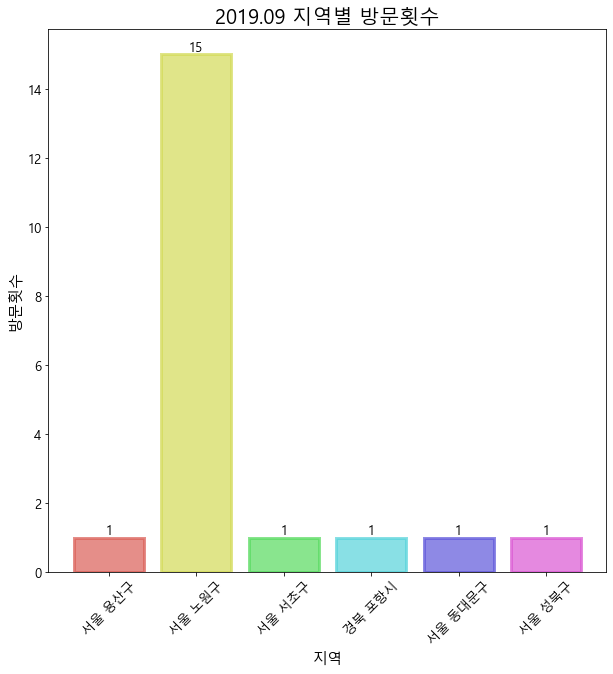

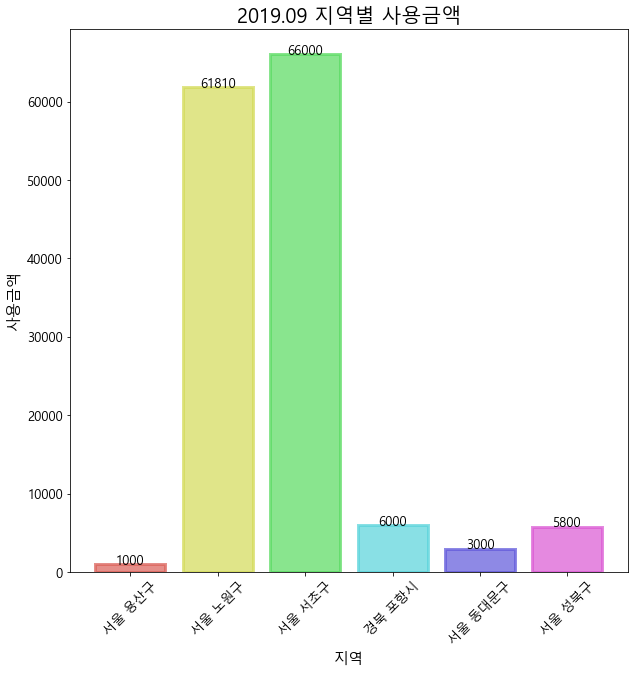

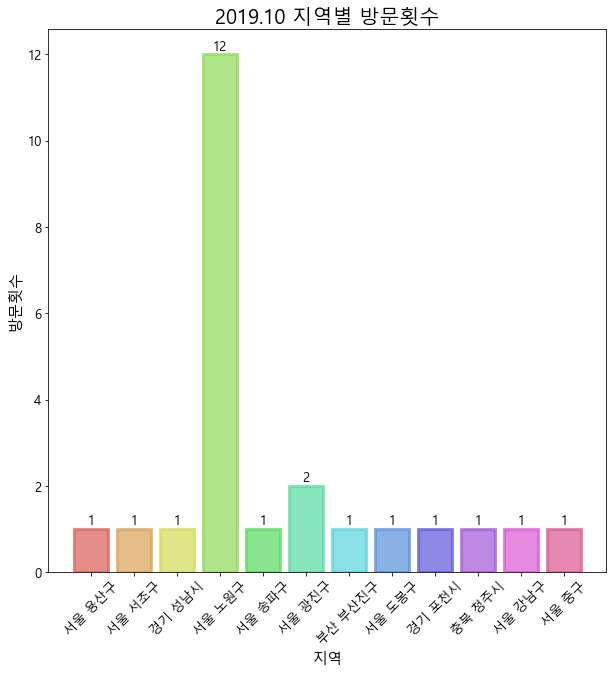

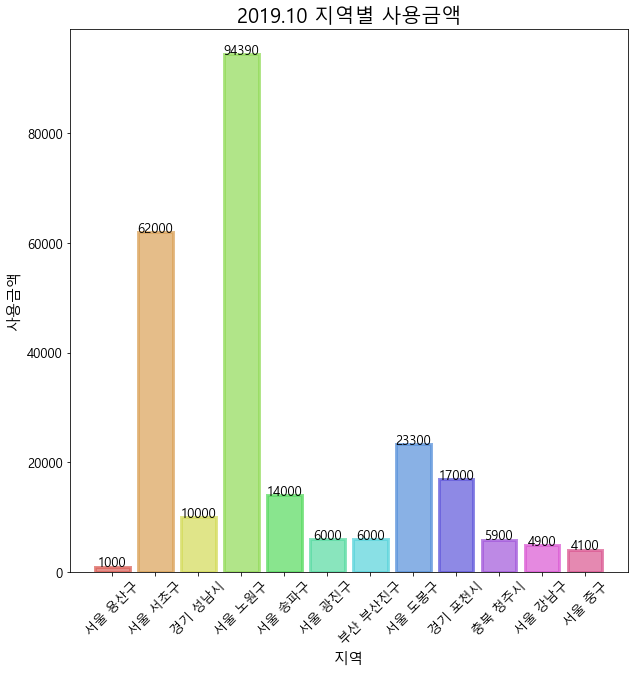

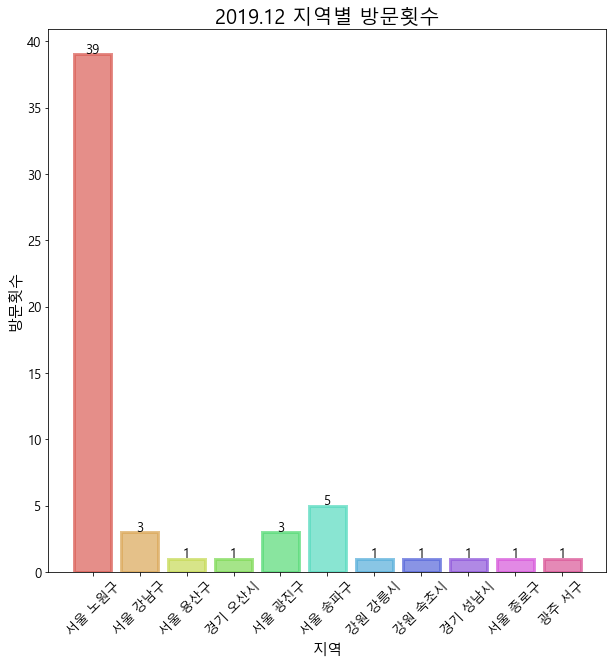

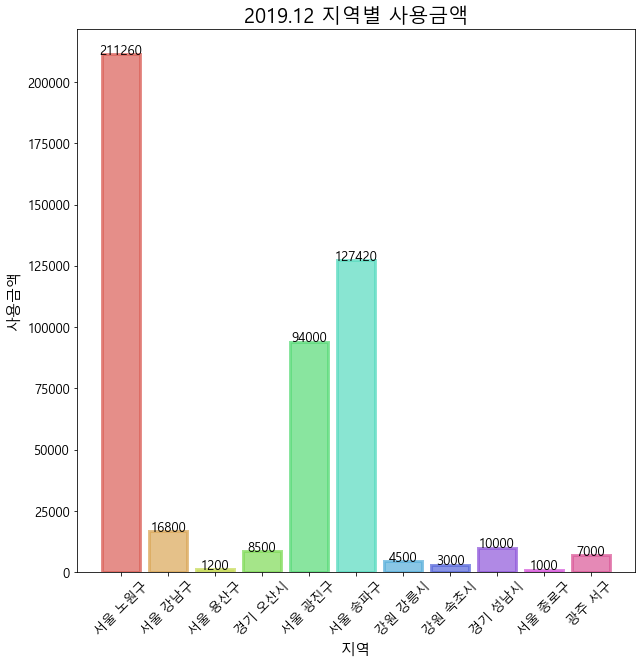

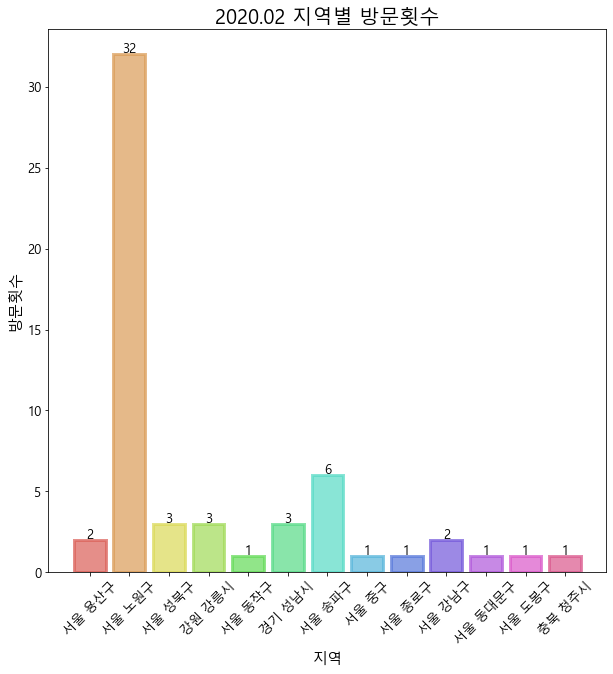

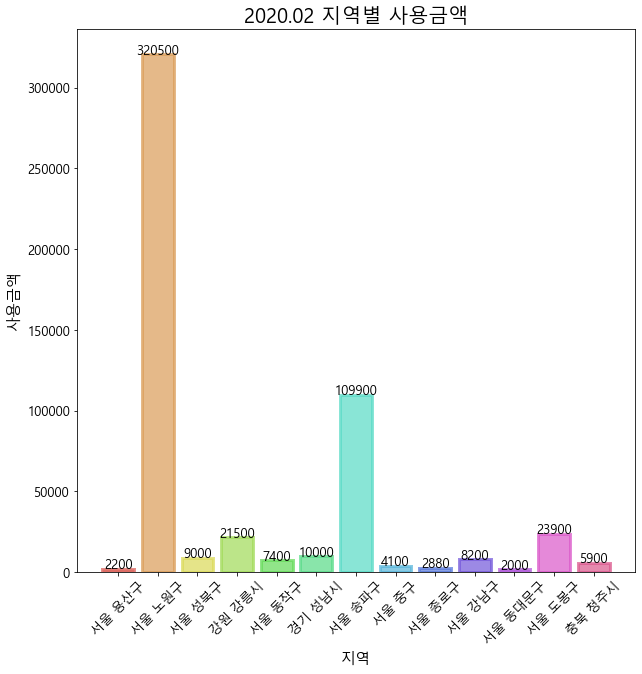

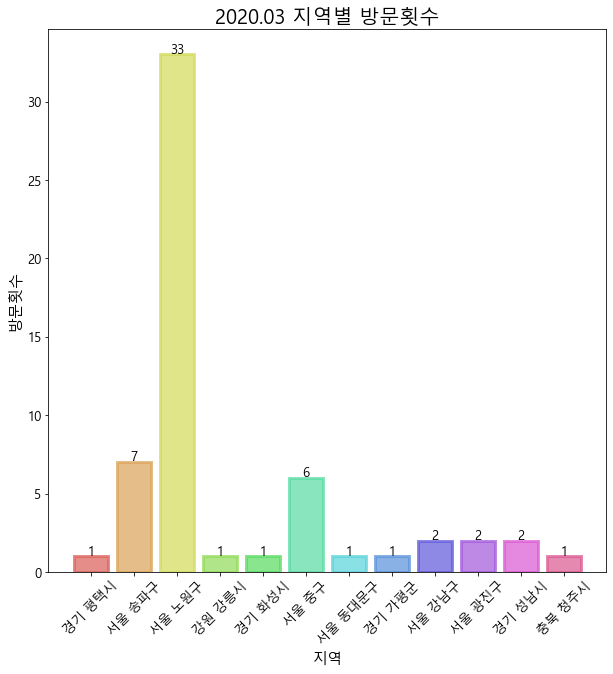

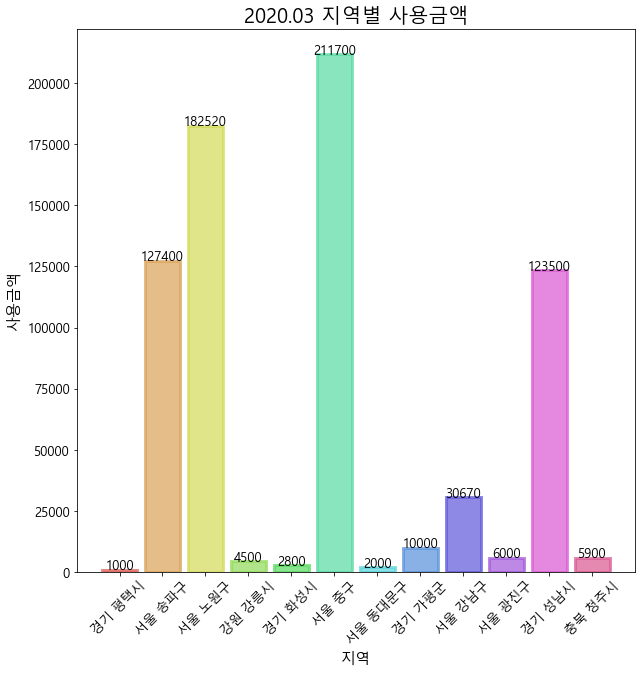

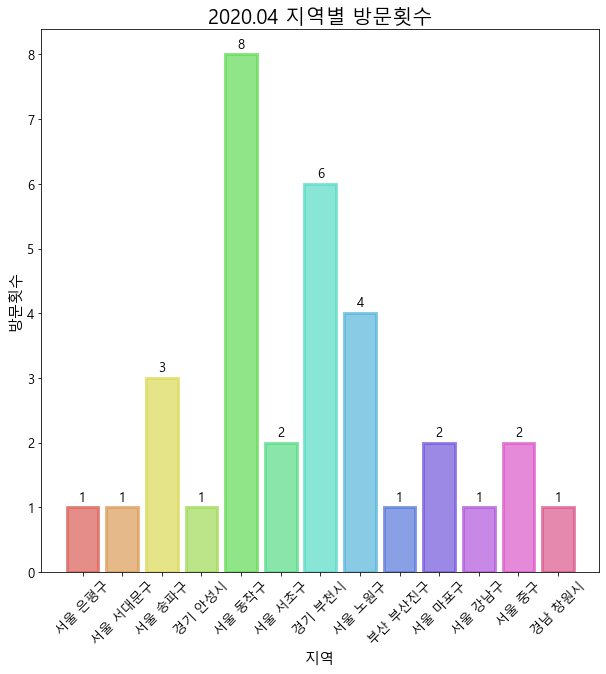

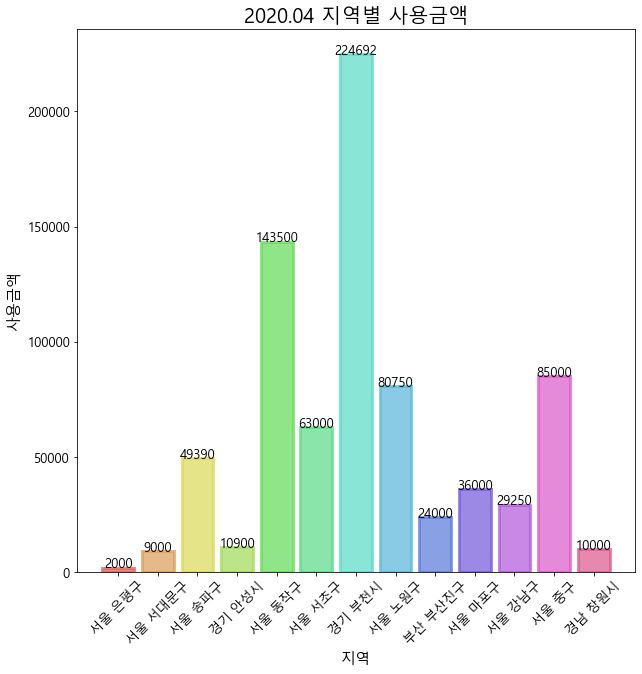

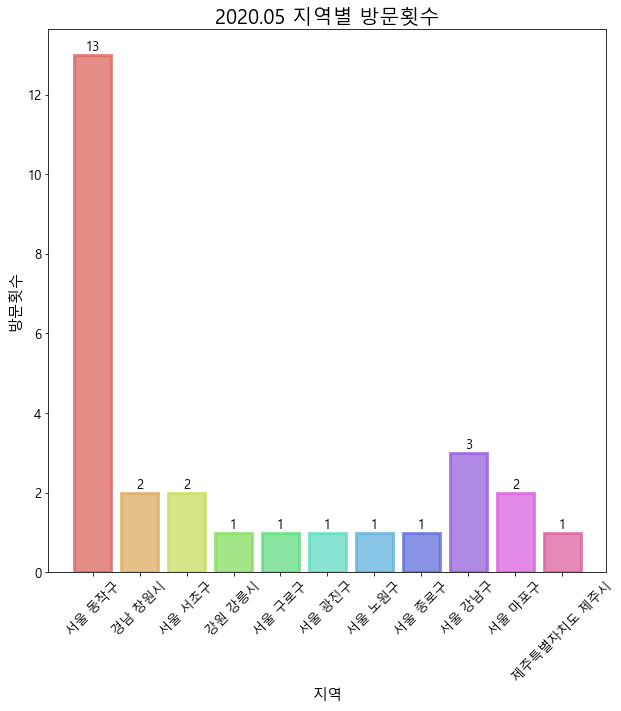

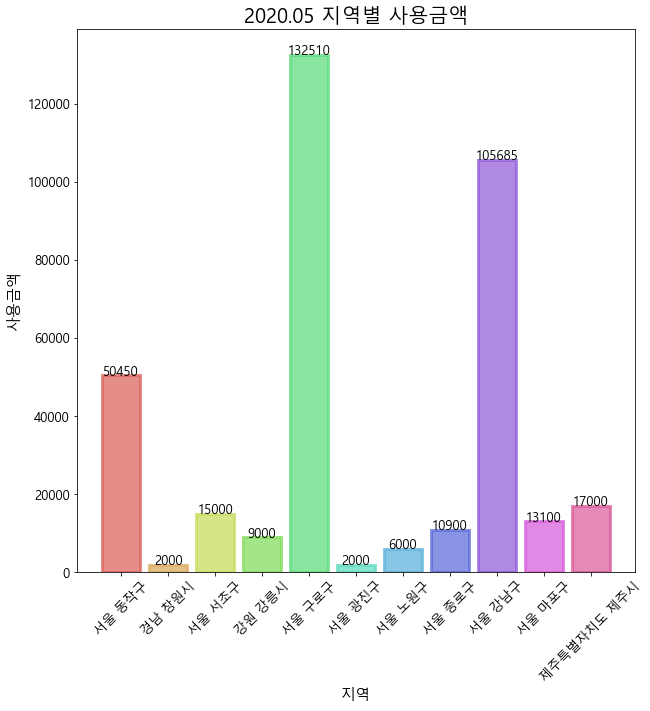

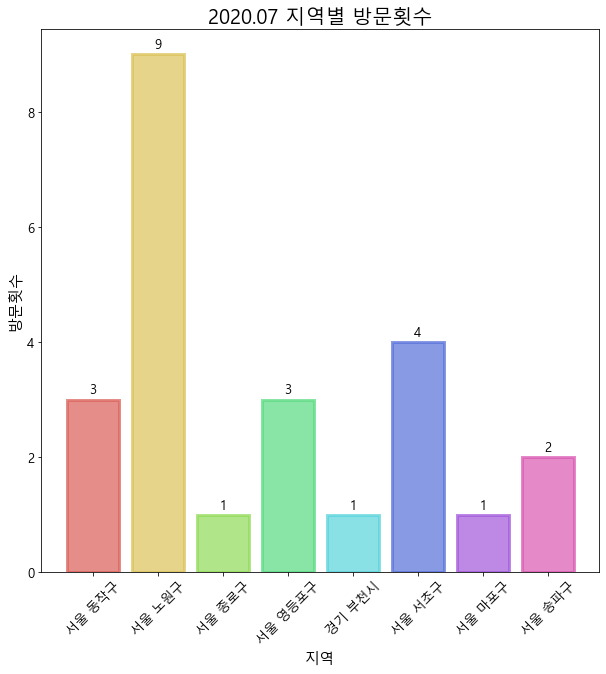

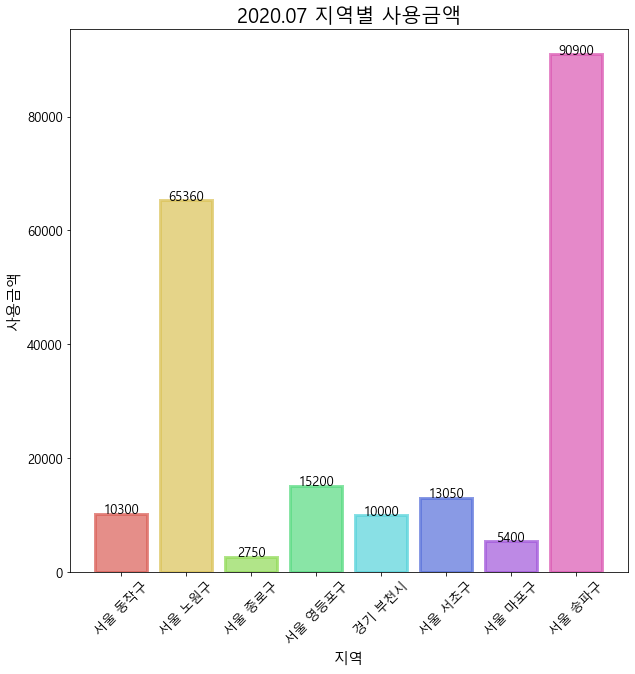

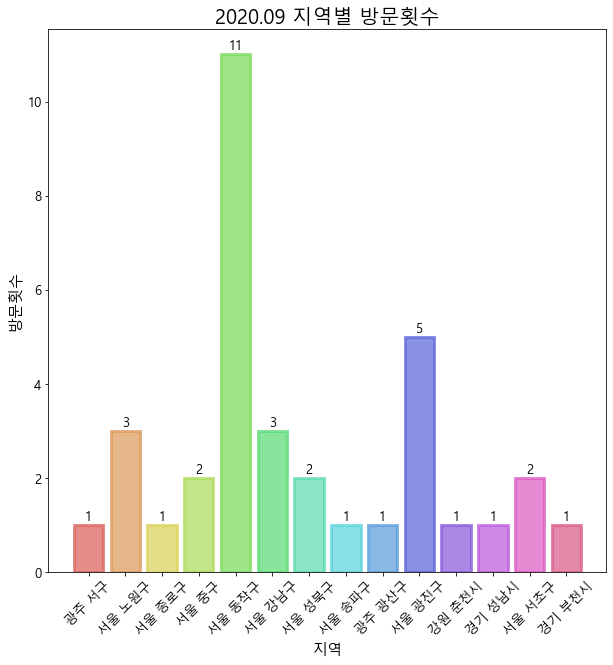

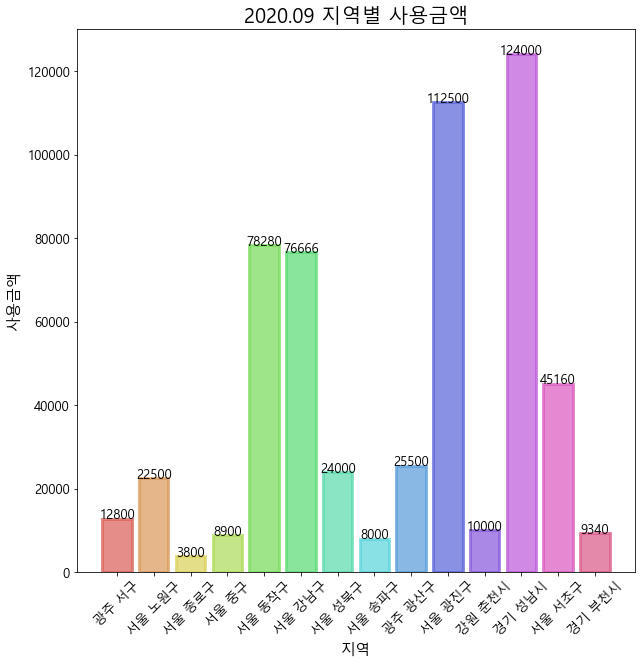

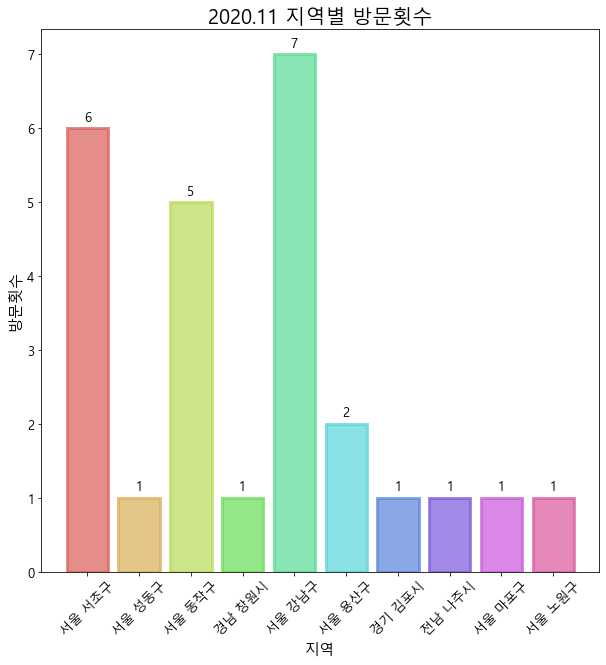

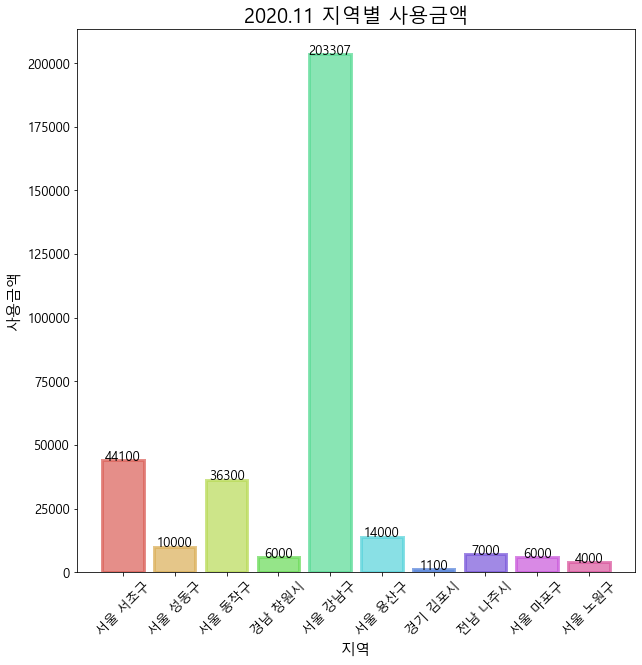

In [197]:
for n in range(len(total_df_region)) :
    c_name = ['방문횟수', '사용금액']
    ta = total_df_region[n]
    sn = sheet_nm[n]
    for k in range(len(c_name)) :
            region_category = ta.index
            visit_category = ta[c_name[k]]
            
            tick_size_1 = 13 ## 눈금 폰트 사이즈
            axis_label_size_1 = 15 ## x축, y축 폰트 사이즈

            fig_1 = plt.figure(figsize=(10,10)) ## Figure 생성 사이즈는 10 by 10
            ax_1 = fig_1.add_subplot() ## Axes 추가
            colors_1 = sns.color_palette('hls',len(region_category)) ## 색상 지정

            xtick_label_position = list(range(len(region_category))) ## x축 눈금 라벨이 표시될 x좌표

            plt.yticks(fontsize=tick_size_1)
            plt.xticks(xtick_label_position, region_category, rotation = 45, fontsize=tick_size_1) ## x축 눈금 라벨 출력

            bars = plt.bar(xtick_label_position, visit_category, color=colors_1, \
                           edgecolor=colors_1, alpha=0.7, linewidth=3) ## 바차트 출력

            for i, b in enumerate(bars):
                ax_1.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                        visit_category[i],ha='center',fontsize=13)

            plt.title(f'{sn} 지역별 {c_name[k]}',fontsize=20) ## 타이틀 출력
            plt.xlabel('지역',fontsize=axis_label_size_1) ## x축 라벨 출력
            plt.ylabel(c_name[k],fontsize=axis_label_size_1) ## y축 라벨 출력

            visit_file = f"C:/Users/Playdata/Desktop/체크카드 명세서/image/{sn}_{c_name[k]}.png"
            plt.savefig(visit_file, dpi = 200)

            plt.show()

In [193]:
region_category

Index(['서울 용산구', '서울 노원구', '서울 서초구', '경북 포항시', '서울 동대문구', '서울 성북구'], dtype='object')

In [188]:
visit_category

서울 용산구      1
서울 노원구     15
서울 서초구      1
경북 포항시      1
서울 동대문구     1
서울 성북구      1
Name: 방문횟수, dtype: int64

In [189]:
total_df_region[0]

,방문횟수,사용금액
서울 용산구,1,1000
서울 노원구,15,61810
서울 서초구,1,66000
경북 포항시,1,6000
서울 동대문구,1,3000
서울 성북구,1,5800


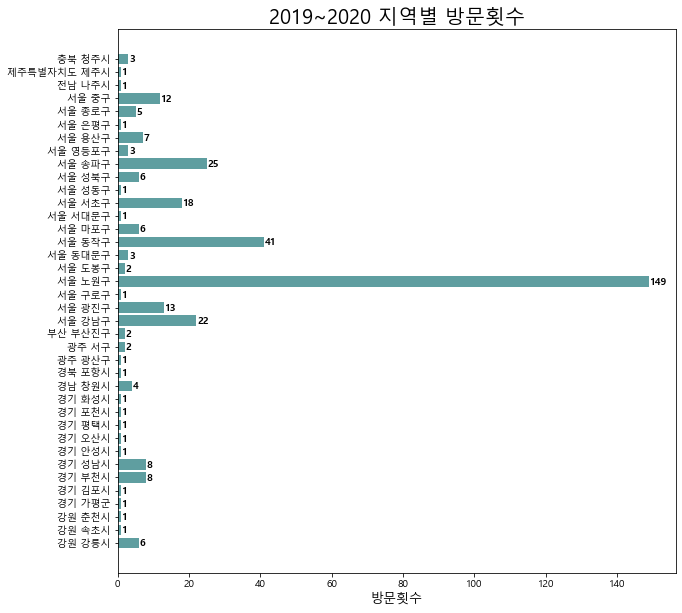

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
 
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']
total_price_category = df_region_NoDup_name['사용금액']

## 시각화
plt.figure(figsize=(10,10)) ## Figure 생성 사이즈

ytick_label_position = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position, total_region_category) ## y축 눈금 라벨 출력

plt.barh(ytick_label_position, total_visit_category, color = 'cadetblue') ## 바차트 출력

for i, v in enumerate(total_visit_category):
    plt.text(v + .2, i - .25, str(v), color='black', fontweight='bold')

ax.set_axisbelow(True)
ax.xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)    
    
    
plt.title('2019~2020 지역별 방문횟수',fontsize=20) ## 타이틀 출력
plt.xlabel('방문횟수',fontsize=13) ## x축 라벨 출력
plt.ylabel('',fontsize=10) ## y축 라벨 출력

graph_file_1 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)

plt.show()

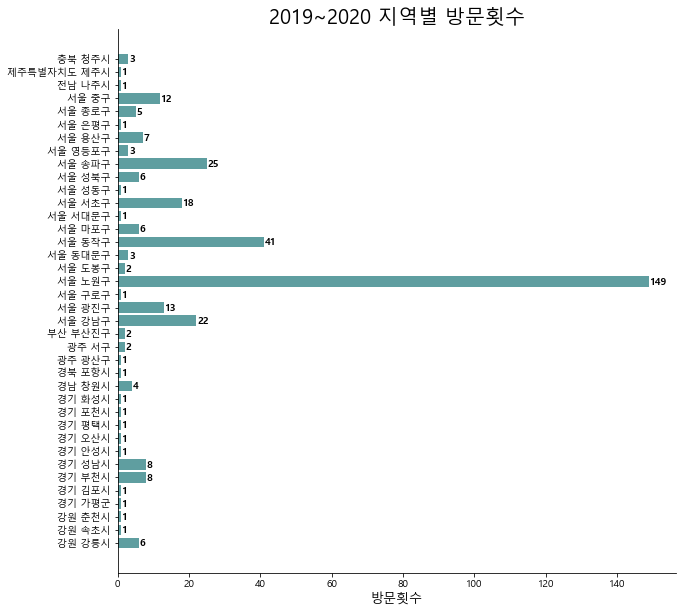

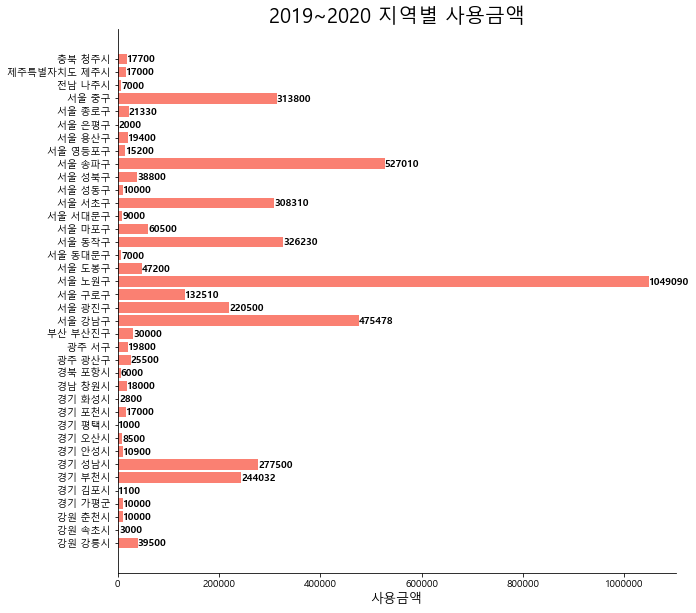

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
 
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']
total_price_category = df_region_NoDup_name['사용금액']

## 시각화
fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position, total_region_category) ## y축 눈금 라벨 출력

plt.barh(ytick_label_position, total_visit_category, color = 'cadetblue') ## 바차트 출력

for i, v in enumerate(total_visit_category):
    plt.text(v + .2, i - .25, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 방문횟수',fontsize=20) ## 타이틀 출력
plt.xlabel('방문횟수',fontsize=13) ## x축 라벨 출력
plt.ylabel('',fontsize=10) ## y축 라벨 출력

graph_file_1 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)
plt.show()

##### 2019~2020 지역별 총 사용금액 ####
fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position_1 = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position_1, total_region_category) ## y축 눈금 라벨 출력
plt.gca().get_xaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기

plt.barh(ytick_label_position_1, total_price_category, color = 'salmon') ## 바차트 출력

for i, v in enumerate(total_price_category):
    plt.text(v + .2, i - .25, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 사용금액',fontsize=20) ## 타이틀 출력
plt.xlabel('사용금액',fontsize=13) ## x축 라벨 출력
plt.ylabel('',fontsize=10) ## y축 라벨 출력

graph_file_2 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_price.png"
plt.savefig(graph_file_2, dpi = 200)

plt.show()

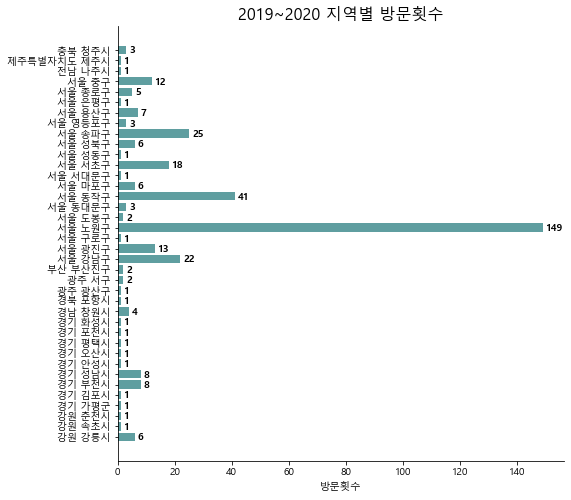

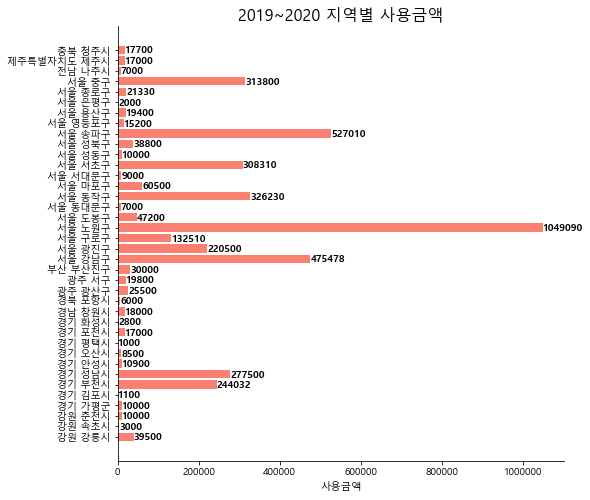

In [182]:
## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']
total_price_category = df_region_NoDup_name['사용금액']

## 시각화
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position, total_region_category) ## y축 눈금 라벨 출력

plt.barh(ytick_label_position, total_visit_category, color = 'cadetblue') ## 바차트 출력

for i, v in enumerate(total_visit_category):
    plt.text(v + .5, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 방문횟수',fontsize=16) ## 타이틀 출력
plt.xlabel('방문횟수',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_1 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)
plt.show()

##### 2019~2020 지역별 총 사용금액 ####
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position_1 = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position_1, total_region_category) ## y축 눈금 라벨 출력
plt.gca().get_xaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기

plt.barh(ytick_label_position_1, total_price_category, color = 'salmon') ## 바차트 출력

for i, v in enumerate(total_price_category):
    plt.text(v + 1, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 사용금액',fontsize=16) ## 타이틀 출력
plt.xlabel('사용금액',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_2 = "C:/Users/Playdata/Desktop/체크카드 명세서/image/total_price.png"
plt.savefig(graph_file_2, dpi = 200)

plt.show()